In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import h5py as h5

In [2]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
from IPython.display import display_html 
styles = [dict(selector="caption", 
    props=[("text-align", "center"),
    ("font-size", "120%"),
    ("color", 'black')])]    # the color value can not be None

image_df = pd.DataFrame({
    'Hit E' :[0], 'Hit X' :[1], 'Hit Y' :[2], 'Hit Depth':[3],
    'Layer 1 Z':[4], 'Layer 2 Z':[5]}, index=['Index'])

truth_df = pd.DataFrame({'Truth E':[0], 'Truth Theta':[1]},index=['Index'])

image_styler = image_df.style.set_table_attributes("style='display:inline'").set_caption('Calo Image Data')
truth_styler = truth_df.style.set_table_attributes("style='display:inline'").set_caption('Truth Particle Data')
display_html(image_styler._repr_html_()+truth_styler._repr_html_(), raw=True)

Calo Image Data 
 
 
   
 Hit E 
 Hit X 
 Hit Y 
 Hit Depth 
 Layer 1 Z 
 Layer 2 Z 
 
 
 
 
 Index 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 

 
 Truth Particle Data 
 
 
   
 Truth E 
 Truth Theta 
 
 
 
 
 Index 
 0 
 1

### Load the Data

In [4]:
filename = 'layered_with0s.hdf5'
h5_file = h5.File(filename,'r')
print(list(h5_file.keys()))
images = h5_file['calo_images']
truth = h5_file['truth']

print(images.shape)
print(truth.shape)
print(images.chunks) # [0] should be = batch_size
print(truth.chunks)


['calo_images', 'truth']
(3920000, 6, 2636)
(3920000, 2, 15)
(100, 6, 2636)
(100, 2, 15)


In [5]:
import h5py
import tensorflow as tf

class generator:
    def __init__(self, file):
        self.file = file

    def __call__(self):
        with h5py.File(self.file, 'r') as hf:
            for im in hf["train_img"]:
                yield im

In [6]:
N_Events = 1_000_000
X = images[0:N_Events]
Y = truth[0:N_Events,0,0]
#Y_Mean = np.nanmean(Y)
#Y_StDev = np.nanstd(Y)
#Y = (Y - Y_Mean)/Y_StDev
#print(type(X))

In [7]:
print(np.shape(X))

(1000000, 6, 2636)


In [8]:
positions = np.where(np.count_nonzero(X,axis=2))

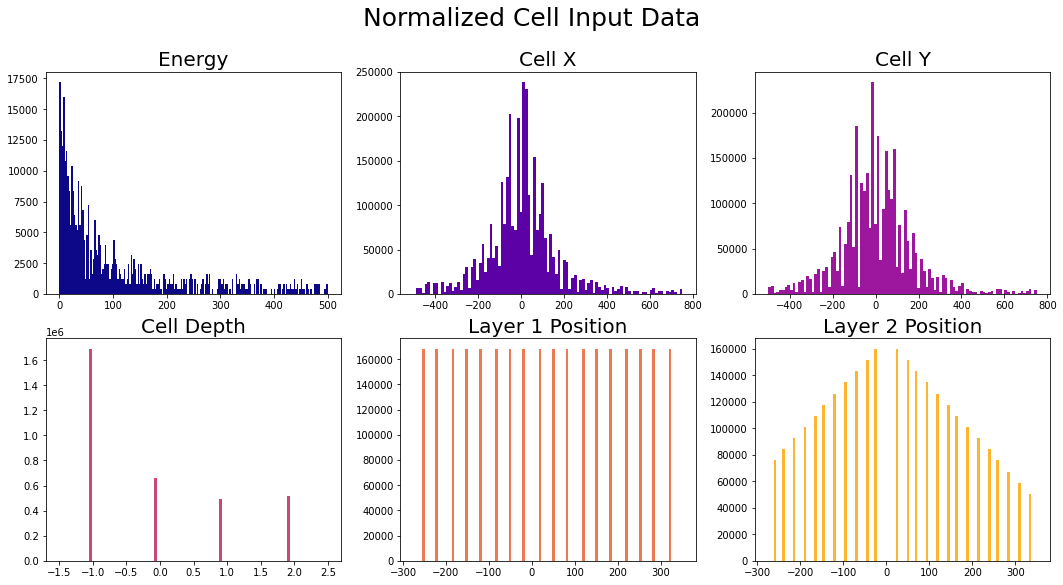

In [9]:
cm = plt.cm.get_cmap('plasma')
cell_vars = ["Energy","Cell X","Cell Y","Cell Depth","Layer 1 Position", "Layer 2 Position"]
bins = [np.linspace(0.01,500,200),np.linspace(-500,751,100),
        np.linspace(-500,751,100),np.linspace(-1.5,2.5,100),
        np.linspace(-275,350,100),np.linspace(-275,350,100)]
data=[]
fig = plt.figure(figsize=(18,9))
#plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
for i in range(images.shape[1]):
    ax = plt.subplot(2, 3, i+1)
    data.insert(i,np.ravel(images[0:10000,i,:]))
    data[i] = data[i][data[i]!=0]
    plt.hist(data[i],bins=bins[i],color=cm(i/images.shape[1]))
    plt.title("%s"%(cell_vars[i]),fontsize=20)
    plt.suptitle("Normalized Cell Input Data",fontsize=25)
plt.savefig("Normalized_Cell_Data.pdf")
    #plt.xlabel('%s [Normalized]'%(cell_vars[i]),fontsize=15)


In [10]:
xi = np.arange(X.shape[0])
yi = np.arange(Y.shape[0])
(X_train, X_val, X_test,
Y_train, Y_val, Y_test) = data_split(X, Y, val=0.2, test=0.3,shuffle=True)

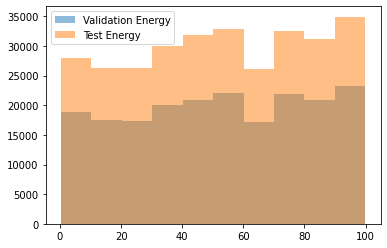

In [11]:
plt.hist(Y_val,alpha=0.5,label="Validation Energy")
_ = plt.hist(Y_test,alpha=0.5,label="Test Energy")
plt.legend()

In [12]:
learning_rate = 0.00001

In [13]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse' #mean-squared error
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 2636)  0           []                               
                                ]                                                                 
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    263700      ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']         

2022-06-17 13:32:28.471091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-06-17 13:32:28.471117: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-17 13:32:28.471408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

In [ ]:
the_fit = pfn.fit(X_train, Y_train,
                  epochs=200,
                  batch_size=400,
                  validation_data=(X_val, Y_val),
                  verbose=1)

2022-06-17 13:32:28.570183: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31632000000 exceeds 10% of free system memory.


Epoch 1/200
1248/1250 [============================>.] - ETA: 0s - loss: 11508.5283 - acc: 0.0000e+00

2022-06-17 13:32:54.972103: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12652800000 exceeds 10% of free system memory.


1250/1250 [==============================] - 23s 18ms/step - loss: 11494.1953 - acc: 0.0000e+00 - val_loss: 2606.4268 - val_acc: 0.0000e+00
Epoch 2/200
1250/1250 [==============================] - 17s 14ms/step - loss: 1808.7218 - acc: 0.0000e+00 - val_loss: 1290.4364 - val_acc: 0.0000e+00
Epoch 3/200
1250/1250 [==============================] - 17s 14ms/step - loss: 1016.6391 - acc: 0.0000e+00 - val_loss: 811.5667 - val_acc: 0.0000e+00
Epoch 4/200
1250/1250 [==============================] - 18s 14ms/step - loss: 667.0032 - acc: 0.0000e+00 - val_loss: 546.8627 - val_acc: 0.0000e+00
Epoch 5/200
1250/1250 [==============================] - 17s 14ms/step - loss: 452.8532 - acc: 0.0000e+00 - val_loss: 372.3397 - val_acc: 0.0000e+00
Epoch 6/200
1250/1250 [==============================] - 17s 14ms/step - loss: 306.5151 - acc: 0.0000e+00 - val_loss: 249.0668 - val_acc: 0.0000e+00
Epoch 7/200
1250/1250 [==============================] - 18s 14ms/step - loss: 203.5125 - acc: 0.0000e+00 - val_

In [ ]:
pfn.layers
pfn.save("energy_regression.h5")
mypreds = pfn.predict(X_test,batch_size=400)

In [ ]:
fig = plt.figure(figsize=(28,10))
ax = plt.subplot(1, 2, 1)
plt.scatter(Y_test,mypreds,alpha=0.3)
plt.xlabel("Y Test [GeV]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.01,100.01)
plt.ylim(-10,110)
plt.ylabel("Y Pred [GeV]",fontsize=22)
_ = plt.title("Prediction vs. Test",fontsize=26)
#FIXME: find indecies in mypreds where mypreds 50

ax = plt.subplot(1, 2, 2)
plt.plot(the_fit.history['loss'])
plt.plot(the_fit.history['val_loss'])
plt.title('Model Loss vs. Epoch',fontsize=26)
plt.text(0.73,0.8," Rate = %1.5f"%(learning_rate),
         transform=ax.transAxes,fontsize=20)
plt.ylabel('Mean-Squared Error',fontsize=22)
plt.yscale('log')
plt.xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
plt.xlim([-1,201])
plt.legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("Prediction_Test.pdf")

In [ ]:
#Binning
N = 50
E_Max = 100
E_Bins = np.linspace(0,E_Max,N+1)

#Goal: slices defined by bin of truthE, filled with pred
indecies = np.digitize(Y_test,E_Bins)
max_count = ((np.bincount(indecies).max()))
slices = np.empty((N,max_count))
slices.fill(np.nan)

counter = np.zeros(N,int)
avg_truth = np.zeros(N,float)

for pred,bin,truth in zip(mypreds,indecies,Y_test):
    slices[bin-1][counter[bin-1]] = pred
    counter[bin-1]+=1
    avg_truth[bin-1]+=truth
    
#Resoluton: stdev(pred)/avg_truth    
avg_truth = avg_truth/counter
stdev_pred = np.nanstd(slices,axis=1)
resolution = stdev_pred/avg_truth

In [ ]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution",fontsize=25)
plt.ylabel("$(\sigma_{E,\mathrm{Pred}}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.02,0.4)
plt.ylim(0,0.22)
plt.xlim(-0.01,100.01)
errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N
plt.errorbar(avg_truth[first_bin:last_bin],resolution[first_bin:last_bin],yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='dodgerblue',alpha=0.7)
_ = plt.text(0.7,0.93,"Stat. Error: $\dfrac{\sigma}{\sqrt{2N-2} } $",transform=ax.transAxes,fontsize=20)
plt.savefig("resolution_plot.pdf")

In [ ]:
fig,axs = plt.subplots(int(N/10),10, figsize=(32, 16),sharex=False,sharey=True,constrained_layout=True)
for i in range(N):
    row = int(i/10)
    col = i%10
    ax = axs[row,col]
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
    temp_bin = np.linspace(avg_truth[i]-2.0,avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]))
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(slices[i],bins=temp_bin,label="Predicted Energies")
    ax.axvline(x=avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(avg_truth[i]))
    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("resolutions_slices.pdf")

In [ ]:
from copy import copy
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(Y_test, mypreds[:,0], bins=[edges, edges])
#xedges=yedges
pcm = axes.pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e3), rasterized=True)
cb = fig.colorbar(pcm, ax=axes, pad=0)
cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes.set_xlabel("Generated Energy",fontsize=22)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(-10,110)
plt.xlim(-10,110)
axes.set_ylabel("Predicted Energy",fontsize=25)
axes.set_title("Predicted vs. Generated Energy",fontsize=30)
plt.savefig("Gen_vs_Pred.pdf")
print(np.size(yedges))

In [ ]:
#Find the peak and zoom in
fig = plt.figure(figsize=(18,5))
plt.suptitle("Predictions",fontsize=25)
ax = plt.subplot(1, 2, 1)
plt.xlabel("Predicted Energy [GeV]",fontsize=18)
bins = np.linspace(0,100,300)
freq = plt.hist(mypreds, bins=bins)

ax = plt.subplot(1, 2, 2)
plt.xlabel("Predicted Energy [GeV]",fontsize=18)
plt.text(0.03,0.9,"[Zoomed In]",transform=ax.transAxes,fontsize=18)
maxbin = np.argmax(freq[0])
zoom = np.linspace(bins[maxbin]-0.01,bins[maxbin]+0.01,100)
mask = np.where(np.logical_and(mypreds>=bins[maxbin]-0.01, mypreds<=bins[maxbin]+0.01))[0]
_ = plt.hist(mypreds[mask],alpha=.3,color="black",bins=zoom)
print("%i / %i Events"%(len(mask),len(mypreds)),"[{:.3%}]".format( (len(mask)/len(mypreds)) ) )

In [ ]:
#plt.hist(np.count_nonzero(np.ravel(X_test[:,1,:])))
weird_data = X_test[mask]
bins = np.linspace(0,1000,20)
fig = plt.figure(figsize=(18,5))
ax = plt.subplot(1,2,1)
plt.hist(np.ravel(np.count_nonzero(X_test,axis=2)),bins=bins)
plt.title("Entire Image Dataset",fontsize=20)
ax = plt.subplot(1,2,2)
plt.title("Weird Cells",fontsize=20)
plt.hist(np.ravel(np.count_nonzero(weird_data,axis=2)),bins=bins)
plt.suptitle("Number of Cell Hits",fontsize=25)

In [ ]:
print(np.ravel(np.count_nonzero(weird_data,axis=2)))

In [ ]:
print(mask[0])

In [ ]:
cm = plt.cm.get_cmap('plasma')
cell_vars = ["Energy","Cell X","Cell Y","Cell Depth","Layer 1 Position", "Layer 2 Position"]
bins = [np.linspace(0.01,500,200),np.linspace(-500,500,100),
        np.linspace(-500,1300,100),np.linspace(-1.5,2.5,100),
        np.linspace(-275,350,100),np.linspace(-275,350,100)]
data=[]
weird_data=X_test[mask]
fig = plt.figure(figsize=(18,9))
#plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
for i in range(images.shape[1]):
    ax = plt.subplot(2, 3, i+1)
    data.insert(i,np.ravel(weird_data[:,i,:]))
    data[i] = data[i][data[i]!=0]
    plt.hist(data[i],bins=bins[i],color=cm(i/images.shape[1]))
    plt.title("%s"%(cell_vars[i]),fontsize=20)
    plt.suptitle("'Weird' Normalized Cell Input Data",fontsize=25)
plt.savefig("weird_Cell_Data.pdf")
    #plt.xlabel('%s [Normalized]'%(cell_vars[i]),fontsize=15)

In [ ]:
cm = plt.cm.get_cmap('plasma')
cell_vars = ["Energy","Cell X","Cell Y","Cell Depth","Layer 1 Position", "Layer 2 Position"]
bins = [np.linspace(0.01,500,200),np.linspace(-500,500,100),
        np.linspace(-500,1300,100),np.linspace(-1.5,2.5,100),
        np.linspace(-275,350,100),np.linspace(-275,350,100)]
weird_data=X_test[mask]
fig = plt.figure(figsize=(18,9))
#plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
for i in range(images.shape[1]-1):
    ax = plt.subplot(2, 3, i+1)
    plt.scatter(np.ravel(weird_data[:,i,:]),np.ravel(weird_data[:,i+1,:]),s=2)
    plt.xlabel(cell_vars[i])
    plt.ylabel(cell_vars[i+1])
    #plt.title("%s"%(cell_vars[i]),fontsize=20)
    plt.suptitle("'Weird' Normalized Cell Scatter Plots",fontsize=25)
plt.savefig("weird_Cell_Data.pdf")